In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
import itertools
from itertools import repeat
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["font.size"] = 14

In [3]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [4]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon


In [5]:
def plot_echelle(k):
        plt.cla()
        # fig, ax = plt.subplots(figsize=(6, 6))
        freq = freqs[k]
        freq_ = freq[np.logical_and(freq.n_p >= 5, freq.n_p <= 9)]
        colors = ('black', '#8B3A3A')
        colors2 = ('#EE6363', '#8B3A3A', '#EE6363')
        for ell in np.unique(freq.l.values):
                Dnu, epsilon = get_fit(ell, freq_)
                nus = freq[freq.l == ell]
                if ell == 0:
                        x = np.append(nus['Re(freq)']%Dnu, nus['Re(freq)']%Dnu + Dnu)
                        y = np.append(nus['Re(freq)'], nus['Re(freq)'])
                        plt.plot(x, y, 'o', 
                                mfc=colors[ell], mec=colors[ell], alpha=0.85,
                                ms=6, mew=1, 
                                label=str(ell))
                else:
                        nus = nus[np.logical_and(nus.n_p >= 1, nus.n_p <= 9)]
                        nu_m0 = nus[nus.m == 0]['Re(freq)'].values
                        x = np.append(nu_m0%Dnu, nu_m0%Dnu + Dnu)
                        y = np.append(nu_m0, nu_m0)
                        plt.plot(x, y, 'o',
                                mfc=colors2[1], mec=colors2[1], alpha=0.85,
                                ms=6, mew=1,
                                label=str(ell))

                        nu_m1 = nus[nus.m == 1]['Re(freq)'].values
                        x = np.append(nu_m1%Dnu, nu_m1%Dnu + Dnu)
                        y = np.append(nu_m1, nu_m1)
                        plt.plot(x, y, '+',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=3, mew=1)
                        
                        nu_m_1 = nus[nus.m == -1]['Re(freq)'].values
                        x = np.append(nu_m_1%Dnu, nu_m_1%Dnu + Dnu)
                        y = np.append(nu_m_1, nu_m_1)
                        plt.plot(x, y, '_',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=3, mew=1)
        plt.legend(title='$\u2113$', loc='upper right')

        plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)

        plt.ylabel(r'Frequency, $d^{-1}$')
        plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu$')
        plt.title(f'{net}, Age = {age_bins[k]:.2f} Myr', size=15)
        plt.grid(alpha=0.5)
        # plt.tight_layout()
        plt.ylim([0, 110])
        plt.xlim([0, 10])

In [6]:
def get_freqs(ind):
    net = nets[ind]
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[ind])
    models = [i[0] for i in prof_index if i[2] in n_profs]
    indexes = hist.index[hist.model_number.isin(models)]
    ages = hist.star_age[indexes]/1e6
    # print(len(freqs), len(ages))
    return freqs, ages


def interp(x, y, age):
    f_linear = interp1d(x, y, bounds_error=False, fill_value=0)
    return f_linear(age)


def model_nlm(ts):
    """
    Creates strings that uniquely identify each mode by the mode IDs.
    
    Input: theoretical spectrum (a pandas df)
    Output: theoretical spectrum (a pandas df) with the string column added.
    """
    id_strings = []
    if "m" not in ts.columns:
        ts["m"] = np.zeros(len(ts))
    for i,row in ts.iterrows():
        id_strings.append(str(int(row["n_pg"]))+str(int(row["l"]))+str(int(row["m"])))
    ts["nlm"] = id_strings
    return ts

mode_labels = ["n1ell0m0","n2ell0m0","n3ell0m0","n4ell0m0","n5ell0m0","n6ell0m0","n7ell0m0","n8ell0m0","n9ell0m0","n10ell0m0",
         "n1ell1mm1","n2ell1mm1","n3ell1mm1","n4ell1mm1","n5ell1mm1","n6ell1mm1","n7ell1mm1","n8ell1mm1","n9ell1mm1","n10ell1mm1",
         "n1ell1m0","n2ell1m0","n3ell1m0","n4ell1m0","n5ell1m0","n6ell1m0","n7ell1m0","n8ell1m0","n9ell1m0","n10ell1m0",
         "n1ell1mp1","n2ell1mp1","n3ell1mp1","n4ell1mp1","n5ell1mp1","n6ell1mp1","n7ell1mp1","n8ell1mp1","n9ell1mp1","n10ell1mp1"]
mode_strings = ["100","200","300","400","500","600","700","800","900","1000",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1",
         "110","210","310","410","510","610","710","810","910","1010",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1"]

In [7]:
def get_freqs_df(ind):
    freqs, ages = get_freqs(ind)
    dff = pd.DataFrame()
    dff["Dnu"] = np.repeat(np.nan, len(freqs))
    dff["eps"] = np.repeat(np.nan, len(freqs))
    for s in mode_labels:
        dff[s] = np.repeat(np.nan, len(freqs))

    freqs_df = []
    for i, row in dff.iterrows():
        df = row
        ts = freqs[i]
        ts = model_nlm(ts)
        df["age"] = ages.iloc[i]
        df["Dnu"] = model_Dnu(ts)
        df["eps"] = model_epsilon(ts)
        for j,s in enumerate(mode_strings):
            try:
                df[mode_labels[j]] = np.round(ts.query(f"nlm=='{s}'")["Re(freq)"].values[0],5)
            except:
                df[mode_labels[j]] = np.nan
        freqs_df.append(df)

    freqs_df = pd.DataFrame(freqs_df)

    l = 1
    for n in range(1, 11):
        freqs_df[f"n{n}ell{l}dfreq"] = freqs_df[f"n{n}ell{l}m0"] - freqs_df[f"n{n}ell{l}mm1"]
        freqs_df.drop(columns=[f"n{n}ell{l}mp1", f"n{n}ell{l}mm1"], inplace=True)
    freqs_df = freqs_df[['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
       'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
       'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
       'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']]
    return freqs_df

In [8]:
def get_freqs_df_interp(ind):
    freqs, ages = get_freqs(ind)
    dff = pd.DataFrame()
    dff["Dnu"] = np.repeat(np.nan, len(freqs))
    dff["eps"] = np.repeat(np.nan, len(freqs))
    for s in mode_labels:
        dff[s] = np.repeat(np.nan, len(freqs))

    freqs_df = []
    for i, row in dff.iterrows():
        df = row
        ts = freqs[i]
        ts = model_nlm(ts)
        df["age"] = ages.iloc[i]
        df["Dnu"] = model_Dnu(ts)
        df["eps"] = model_epsilon(ts)
        for j,s in enumerate(mode_strings):
            try:
                df[mode_labels[j]] = np.round(ts.query(f"nlm=='{s}'")["Re(freq)"].values[0],5)
            except:
                df[mode_labels[j]] = np.nan
        freqs_df.append(df)

    freqs_df = pd.DataFrame(freqs_df)

    l = 1
    for n in range(1, 11):
        freqs_df[f"n{n}ell{l}dfreq"] = freqs_df[f"n{n}ell{l}m0"] - freqs_df[f"n{n}ell{l}mm1"]
        freqs_df.drop(columns=[f"n{n}ell{l}mp1", f"n{n}ell{l}mm1"], inplace=True)
    columns = ['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
       'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
       'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
       'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']
    freqs_df = freqs_df[columns]
    
    # ages = np.linspace(15, freqs_df.iloc[-1]["age"], 100)
    ages = np.arange(0, freqs_df.iloc[-1]["age"], 0.01)
    new_df = pd.DataFrame()
    new_df["age"] = ages
    for column in columns[1:]:
        new_df[column] = interp(freqs_df["age"], freqs_df[column], ages)
    return new_df

In [9]:
def plot_freq_df(row):
    plt.cla()
    row = row[1]
    freqs_0 = row[3:13].values
    freqs_1 = row[13:].values
    age = row.age
    Dnu = row.Dnu
    eps = row.eps
    colors = ('black', '#8B3A3A')
    colors2 = ('#EE6363', '#8B3A3A', '#EE6363')
    for ell in [0, 1]:
        freqs = np.array(freqs_0) if ell == 0 else np.array(freqs_1)
        x = np.append(freqs%Dnu, freqs%Dnu + Dnu)
        y = np.append(freqs, freqs)
        plt.plot(x, y, 'o', 
                    mfc=colors[ell], mec=colors[ell], alpha=0.85,
                    ms=6, mew=1, 
                    label=str(ell))
    plt.legend(title='$\u2113$', loc='upper right')

    plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)

    plt.ylabel(r'Frequency, $d^{-1}$')
    plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu$')
    plt.title(f'{gyre_}, Age = {age:.2f} Myr', size=15)
    plt.grid(alpha=0.5)
    # plt.tight_layout()
    plt.ylim([0, 110])
    # plt.xlim([0, Dnu*1.2])
    plt.xlim([0, 10])

In [54]:
logs_dirs = glob.glob("../test/m1.7_z0.015_v0_net*/LOGS")
nets = [" ".join(logs_dir.split('/')[-2].split('net')[-1].split("_")) for logs_dir in logs_dirs]
run_times = []
for i, logs_dir in enumerate(logs_dirs):
    logfn = "".join(logs_dir.split("LOGS")) + "run.log"
    with open(logfn, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Total" in line:
                run_time = float(line.split(" ")[-2])
                run_times.append(run_time)
# logs_dirs
print(run_times)
print(nets)
net_labels = ['hot\_cno', 'pp\_and\_cno\_extras', 'pp\_extras', 'pp\_extras\ +\ hot\_cno', 'basic']


[174.75741481781006, 282.2259466648102, 158.2733702659607, 253.6868007183075, 128.95581531524658]
['hot cno', 'pp and cno extras', 'pp extras', 'pp and hot cno', 'basic']


In [16]:
freqs_df_all = []
for i, net in enumerate(nets):
    freqs_df = get_freqs_df_interp(i)
    freqs_df_all.append(freqs_df)

In [17]:
runtime_ratios = []
for i in range(len(nets)):
    runtime_ratios.append(round(run_times[i]/run_times[1], 2))
runtime_ratios

[0.62, 1.0, 0.56, 0.9, 0.46]

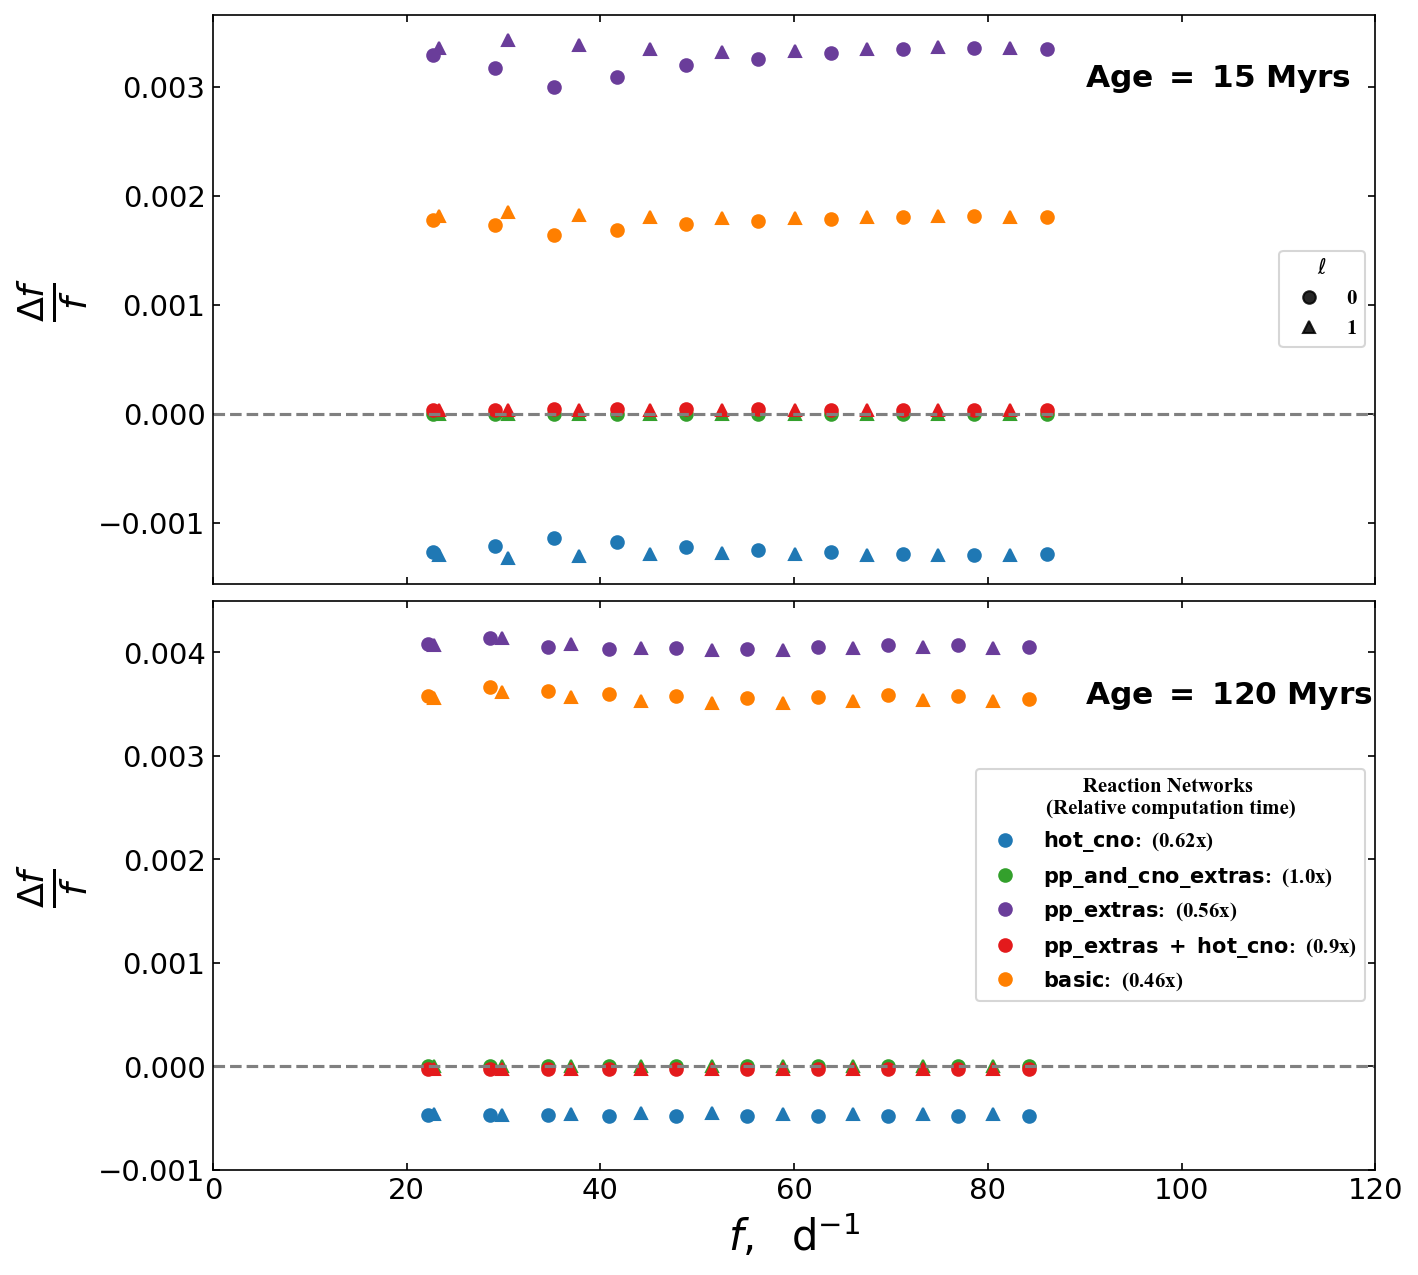

In [36]:
fig = plt.figure(figsize=(10, 10))
palette = sorted(sns.color_palette("Paired_r", 5))
# palette = sorted(sns.color_palette("colorblind", 5))
# palette = sns.color_palette("Set1", 5)
# palette = sns.color_palette("tab10_r", 5)
# palette = ["firebrick", "olive", "darkcyan", "navy", "thistle"]

ax = plt.subplot(2, 1, 1)
freqs_df = freqs_df_all[1]
row = freqs_df.query('age == 15')
i = row.index[0] 
freqs_0 = row[row.columns[3:13]].values[0]
freqs_1 = row[row.columns[13:22]].values[0]


for ind, net_alt in enumerate(nets):
    freqs_df_alt = freqs_df_all[ind]
    freqs_alt_0 = freqs_df_alt.iloc[i][3:13].values
    freqs_alt_1 = freqs_df_alt.iloc[i][13:22].values
    age = row.age.iloc[0]
    Dnu = row.Dnu.iloc[0]
    for ell in [0, 1]:
        freqs = np.array(freqs_0) if ell == 0 else np.array(freqs_1)
        x = freqs
        freq_diff = np.array((freqs_0 - freqs_alt_0)/freqs_0) if ell == 0 else np.array((freqs_1 - freqs_alt_1)/freqs_1)
        y = freq_diff
        if ell == 0:
            plt.plot(x, y, 'o',
                        ms=6, color=palette[ind], mew=1)
        else:
            plt.plot(x, y, '^',
                        ms=6, mew=1, color=palette[ind])
font = mpl.font_manager.FontProperties(family= 'Times new roman', 
                                   weight='bold',
                                   style='normal', size=10)
plt.plot([], [], 'o', alpha=0.85, ms=6, color='k', mew=1, label="0")
plt.plot([], [], '^', alpha=0.85, ms=6, mew=1, color='k', label = "1")
plt.axhline(0,ls='dashed',color='grey')
plt.ylabel(r'$\frac{\Delta f}{f}$', size=25)
txt = plt.text(90, 0.003, r"$\bf{Age\ =\ 15\ Myrs}$", size=15)
plt.subplots_adjust(wspace=0, hspace=0.03)

plt.xlim([0, 120])
plt.legend(title='$\u2113$', loc='center right', fontsize=15, title_fontproperties=font, prop=font)
ax.set_xticklabels([])

ax = plt.subplot(2, 1, 2)
freqs_df = freqs_df_all[1]
row = freqs_df.query('age == 120')
i = row.index[0] 
freqs_0 = row[row.columns[3:13]].values[0]
freqs_1 = row[row.columns[13:22]].values[0]

for ind, net_alt in enumerate(nets):
    net_alt = nets[ind]
    freqs_df_alt = freqs_df_all[ind]
    freqs_alt_0 = freqs_df_alt.iloc[i][3:13].values
    freqs_alt_1 = freqs_df_alt.iloc[i][13:22].values
    age = row.age.iloc[0]
    Dnu = row.Dnu.iloc[0]
    for ell in [0, 1]:
        freqs = np.array(freqs_0) if ell == 0 else np.array(freqs_1)
        x = freqs
        freq_diff = np.array((freqs_0 - freqs_alt_0)/freqs_0) if ell == 0 else np.array((freqs_1 - freqs_alt_1)/freqs_1)
        y = freq_diff
        if ell == 0:
            plt.plot(x, y, 'o',
                        ms=6, color=palette[ind], mew = 1,
                        label=fr"$\bf{{{net_labels[ind]}}}$"+f":  ({runtime_ratios[ind]}x)")
        else:
            plt.plot(x, y, '^',
                        ms=6, mew=1, color=palette[ind])
            

plt.text(90, 0.0035, r"$\bf{Age\ =\ 120\ Myrs}$", size=15)
plt.legend(title="       Reaction Networks\n(Relative computation time)", loc='center right', 
                    title_fontproperties=font, prop=font, fontsize=10, fancybox=True)
plt.axhline(0,ls='dashed',color='grey')
plt.xlim([0, 120])
plt.ylim([-0.001, 0.0045])
plt.xlabel(r"$f, \ \ \rm{d}^{-1}$", size=20)
plt.ylabel(r'$\frac{\Delta f}{f}$', size=25)
plt.subplots_adjust(wspace=0, hspace=0.03)
plt.savefig(f'figures/diff_all.png', dpi=300, bbox_inches='tight')

In [181]:
color = plt.cm.rainbow(np.linspace(0, 1, 5))
def plot_freq_diff(row):
    i, row = row
    plt.cla()
    freqs_0 = row[3:13].values
    freqs_1 = row[13:22].values

    for ind, net_alt in enumerate(nets):
        freqs_df_alt = freqs_df_all[ind]
        freqs_alt_0 = freqs_df_alt.iloc[i][3:13].values
        freqs_alt_1 = freqs_df_alt.iloc[i][13:22].values
        age = row.age
        Dnu = row.Dnu
        for ell in [0, 1]:
            freqs = np.array(freqs_0) if ell == 0 else np.array(freqs_1)
            x = freqs
            freq_diff = np.array((freqs_0 - freqs_alt_0)/freqs_0) if ell == 0 else np.array((freqs_1 - freqs_alt_1)/freqs_1)
            y = freq_diff
            if ell == 0:
                plt.plot(x, y, 'o',
                            ms=6, color=palette[ind], mew=1)
            else:
                plt.plot(x, y, '^',
                            ms=6, mew=1, color=palette[ind], label = str(net_alt))
    font = mpl.font_manager.FontProperties(family= 'Times new roman', 
                                    weight='bold',
                                    style='normal', size=10)
    plt.axhline(0,ls='dashed',color='grey')
    plt.xlabel(r"$f, \ \ \rm{d}^{-1}$", size=20)
    plt.ylabel(r'$\Delta f/f$', size=25)
    # plt.grid(alpha=0.5)
    font = mpl.font_manager.FontProperties(family= 'Times new roman', 
                                   weight='bold',
                                   style='normal', size=10)
    legend = plt.legend(title="           Reaction Networks\n(Relative computational speeds)", loc='upper right', 
                    title_fontproperties=font, prop=font, fontsize=10, fancybox=True)
    plot0 = plt.plot([], [], 'o', alpha=0.85, ms=6, color='k', mew=1, label="0")
    plot1 = plt.plot([], [], '^', alpha=0.85, ms=6, mew=1, color='k', label = "1")
    legend1 = plt.legend(['0', '1'], loc=4, title='$\u2113$')
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend)
    plt.xlim([0, 110])
    plt.ylim([-0.06, 0.05])
    plt.title(f'Age = {age:.1f} Myr', size=15)
    

In [ ]:
freqs_df_all[0][50:70]

/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_7608/632434143.py:3: UserWarning: frames=<generator object DataFrame.iterrows at 0x179e68480> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, plot_freq_diff, frames=freqs_df_all[1][39:151].iterrows(), repeat=False)
/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_7608/3703445354.py:17: RuntimeWarning: invalid value encountered in divide
  freq_diff = np.array((freqs_0 - freqs_alt_0)/freqs_0) if ell == 0 else np.array((freqs_1 - freqs_alt_1)/freqs_1)
/Users/anujgautam/.pyenv/versions/3.11.3/lib/python3.11/site-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for

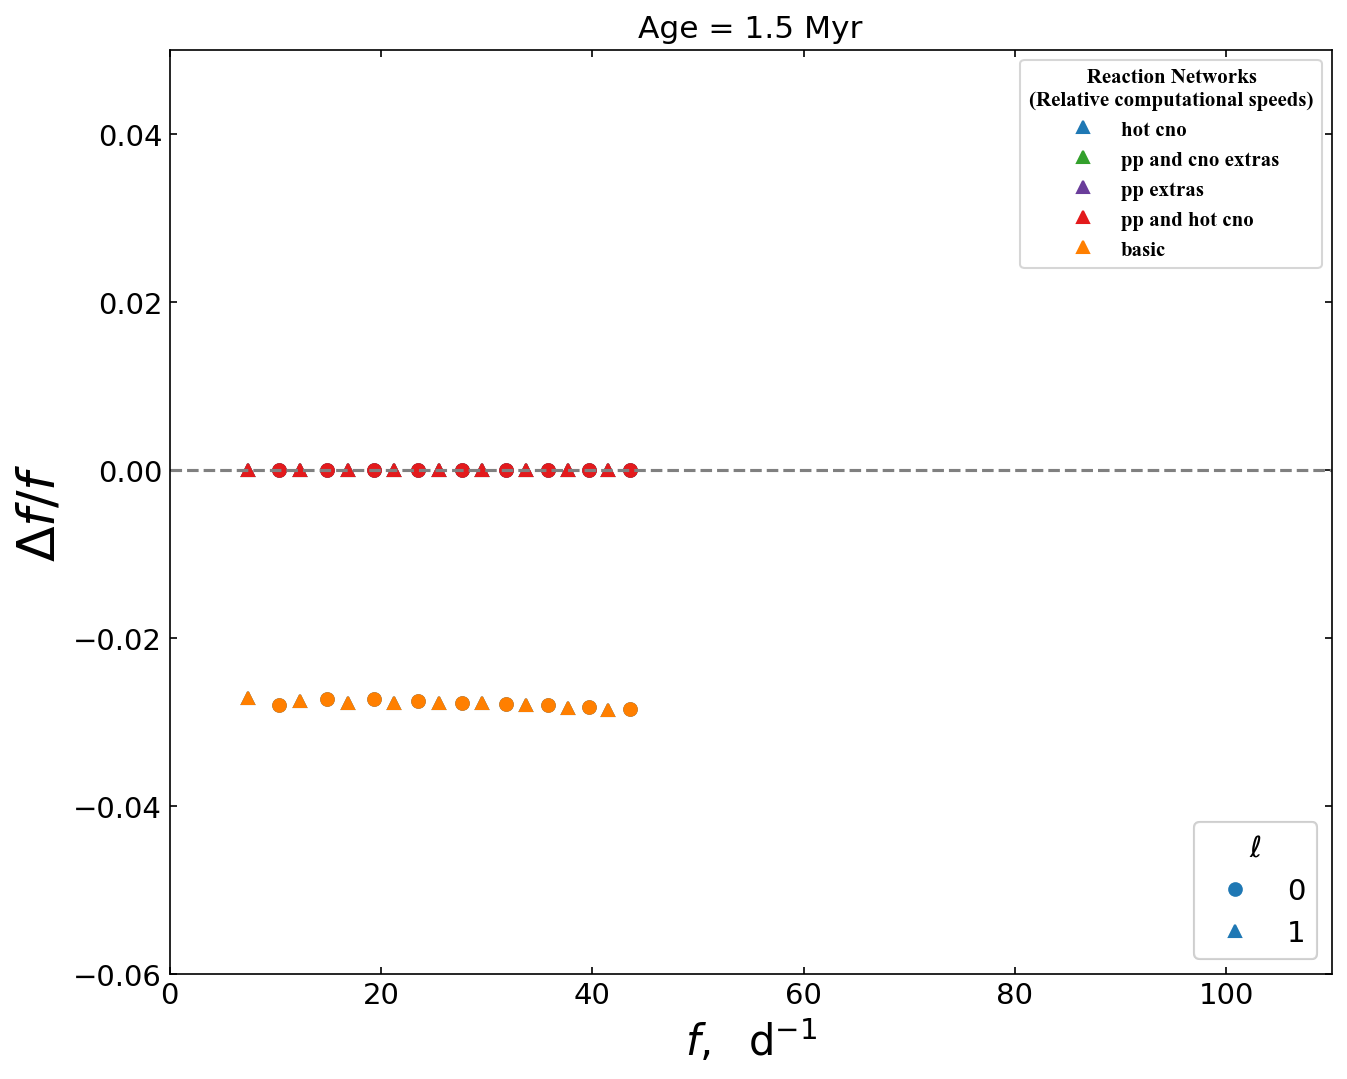

In [178]:
fig, ax = plt.subplots(figsize=(10, 8))
freqs_df_all[1]
ani = FuncAnimation(fig, plot_freq_diff, frames=freqs_df_all[1][39:151].iterrows(), repeat=False)
ani.save(f'figures/diff_all.gif', writer='pillow', dpi=300, savefig_kwargs={"bbox_inches": "tight"})

In [ ]:
for row in freqs_df_all[0].iterrows():
    i, row = row
    # print(row)
    i = row.index[0] 
    # print(row.age)
    freqs_0 = row[3:13]
    # print(freqs_0.values)
    freqs_1 = row[13:]

In [94]:
freqs_df_all[-1].iloc[0][3:22].values

array([22.63103993, 29.0872135 , 35.18806591, 41.65814506, 48.73509174,
       56.15859595, 63.65403769, 71.08427016, 78.46898118, 85.91992719,
       23.25427351, 30.43711491, 37.71469558, 45.06496375, 52.48643549,
       59.9892226 , 67.41342329, 74.75277933, 82.10310285])

In [19]:
mean_diffs = []
age = freqs_df_all[1]['age'].values
for ind, net in enumerate(nets):
    net_alt = nets[ind]
    freqs_df_alt = freqs_df_all[ind]
    this_mean = []
    for i, row in freqs_df_all[1].iterrows():
        freqs_0 = row[3:13].values
        freqs_1 = row[13:22].values
        freqs_alt_0 = freqs_df_alt.iloc[i][3:13].values
        freqs_alt_1 = freqs_df_alt.iloc[i][13:22].values
        mean = np.mean(np.append((freqs_0 - freqs_alt_0)/freqs_0, (freqs_1 - freqs_alt_1)/freqs_1))
        this_mean.append(mean)
    mean_diffs.append(this_mean)
        

/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_56893/3937358195.py:12: RuntimeWarning: invalid value encountered in divide
  mean = np.mean(np.append((freqs_0 - freqs_alt_0)/freqs_0, (freqs_1 - freqs_alt_1)/freqs_1))


In [60]:
font.get_family()

['Serif']

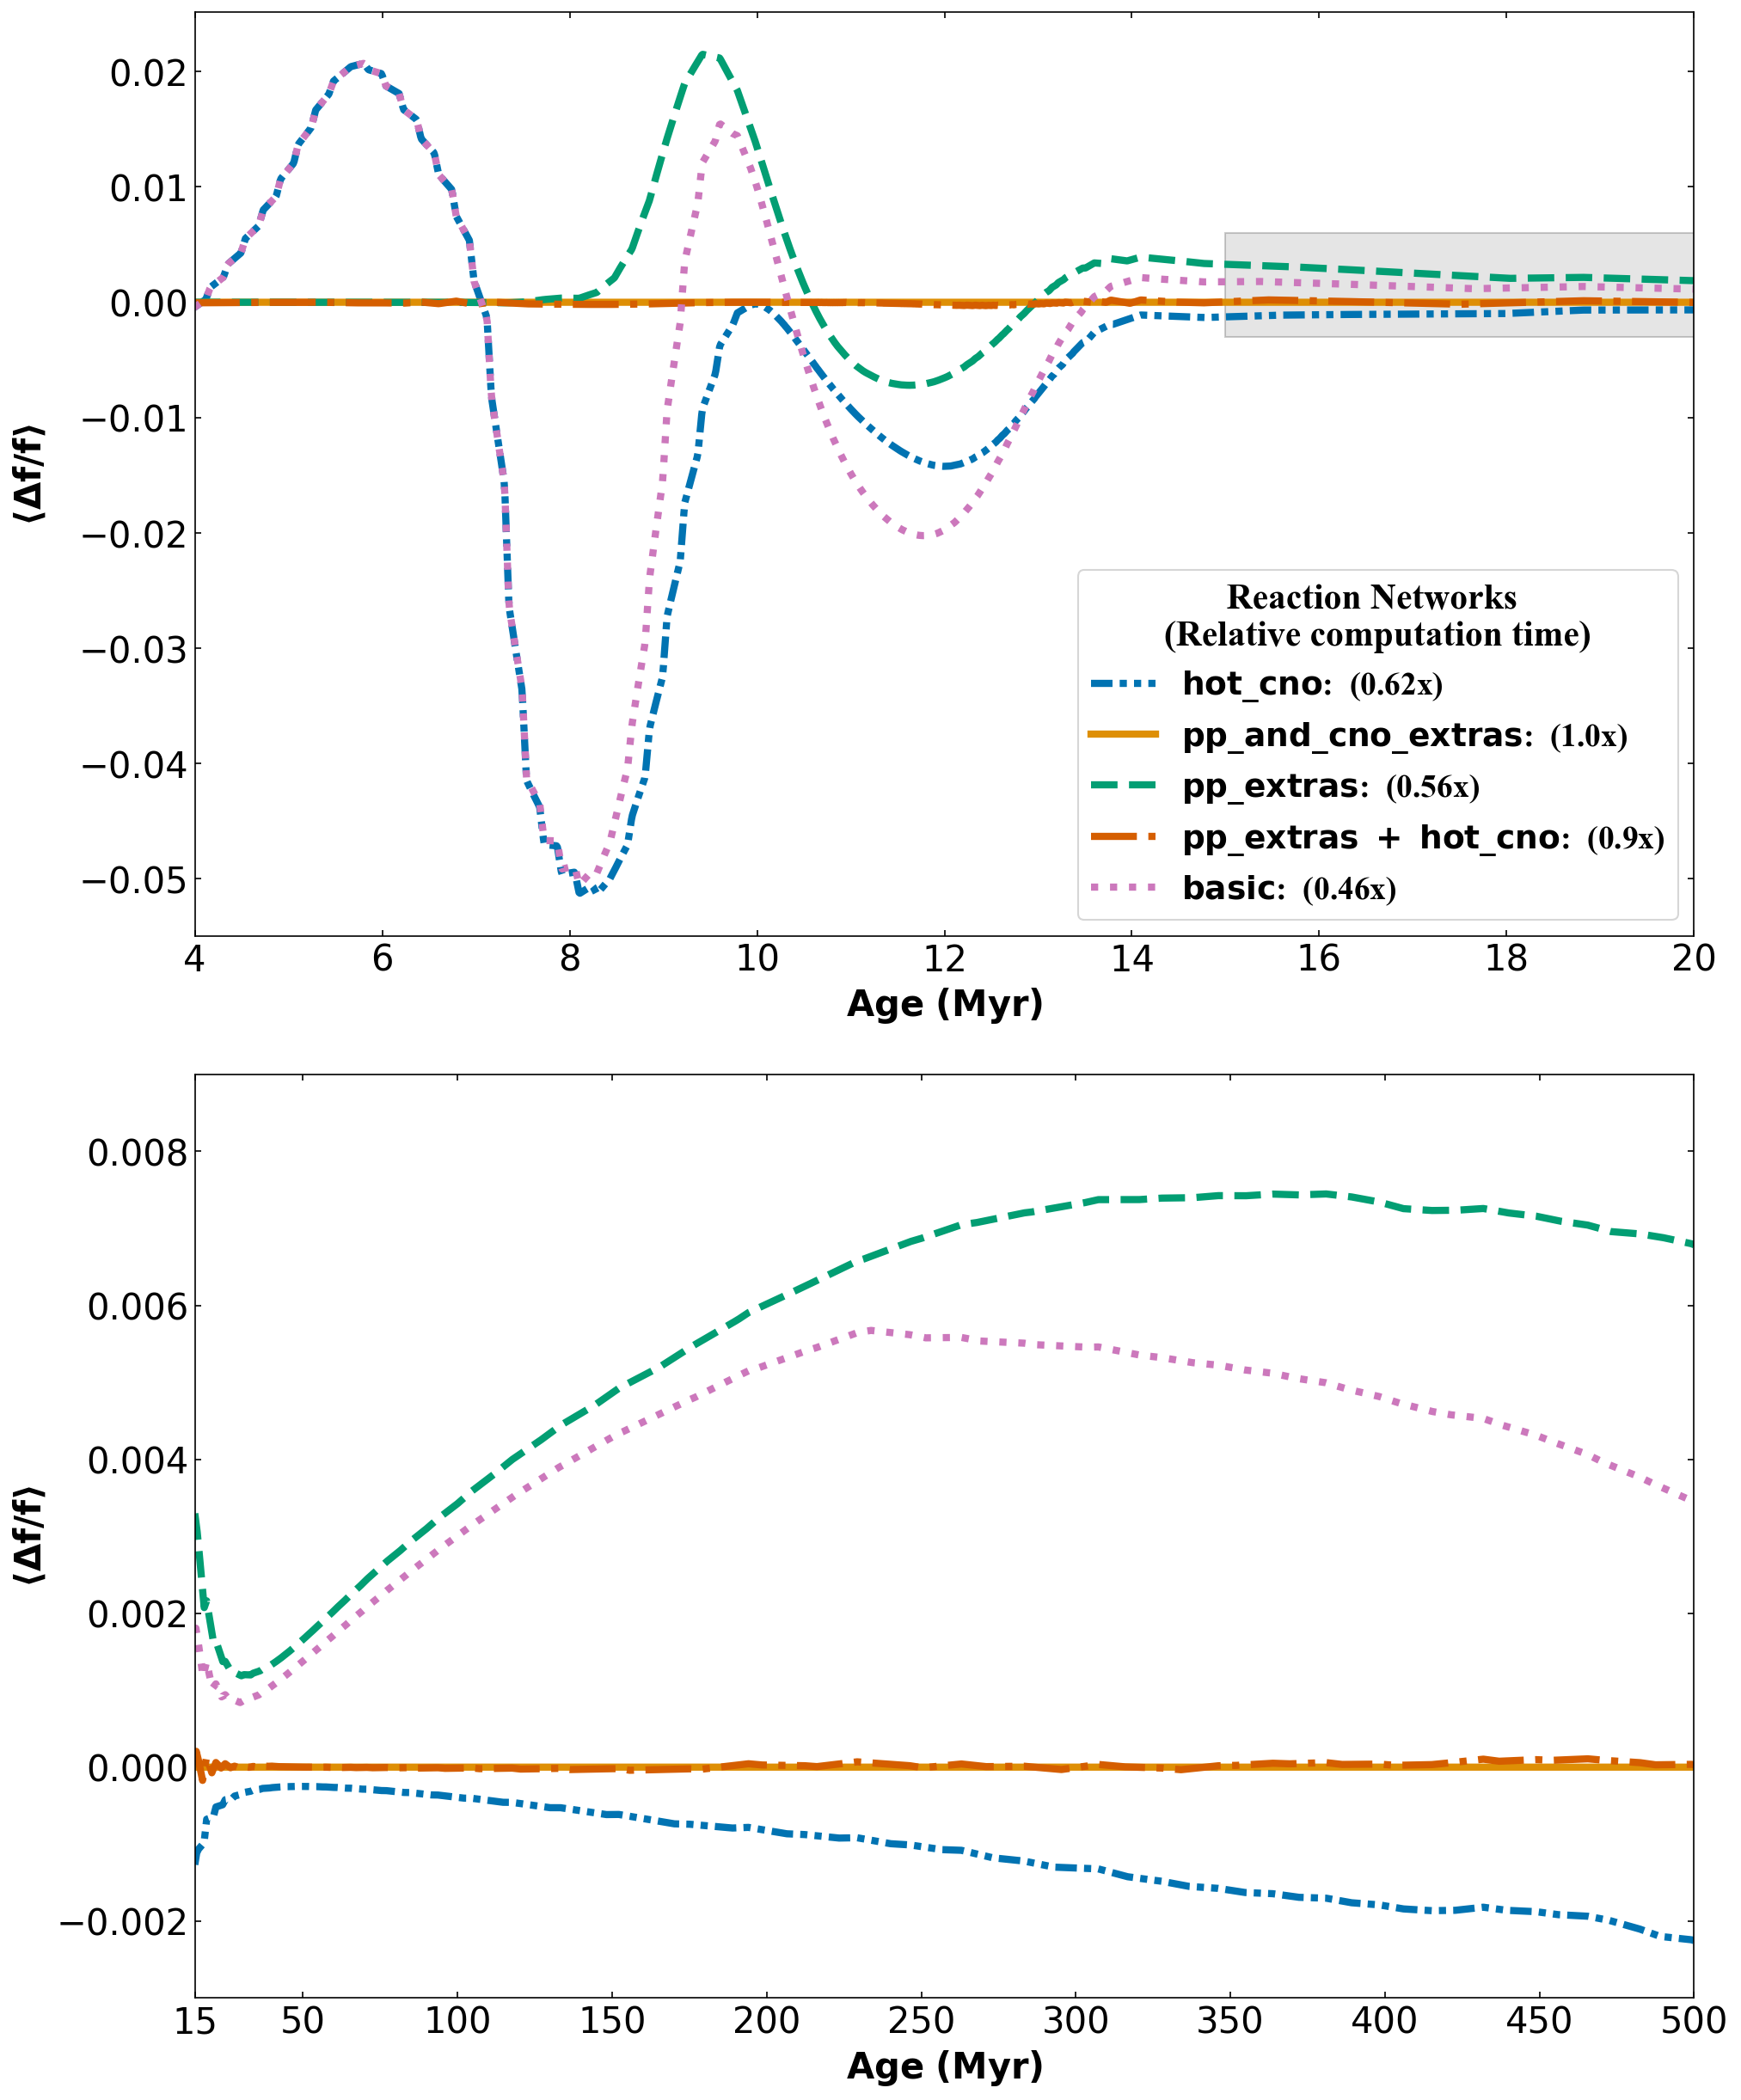

In [64]:
fig = plt.figure(figsize=(15, 20))
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("colorblind", 5)
# palette = ['#7a1679', '#0000ef', '#5fc9ca', '#377e2b', '#ea332c']

ax1 = plt.subplot(2, 1, 1)
for ind, net in enumerate(nets):
    plt.plot(age, mean_diffs[ind], color=palette[ind], linestyle=linestyle_tuple[ind], lw=4,
            label=fr"$\bf{{{net_labels[ind]}}}$"+f":  ({runtime_ratios[ind]}x)")
            # label=f"{net_labels[ind]}"+f":  ({runtime_ratios[ind]}x)")

title_font = mpl.font_manager.FontProperties(family= 'Times new roman',
                                   weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(family='Times new roman',
                                   weight='bold',
                                   style='normal', size=18)
legend = plt.legend(title="       Reaction Networks\n(Relative computation time)", loc='lower right', 
                title_fontproperties=title_font, prop=font, fancybox=True)
plt.xlim([4, 20])
plt.xticks(np.arange(4, 22, 2))
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\Delta f/f}} \rangle$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
rect = mpl.patches.Rectangle((15, -0.003), 20, 0.009, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
ax1.add_patch(rect)

ax2 = plt.subplot(2, 1, 2)
for ind, net in enumerate(nets):
    plt.plot(age, mean_diffs[ind], color=palette[ind], linestyle=linestyle_tuple[ind], lw=4,
             label=fr"$\bf{{{net_labels[ind]}}}$"+f":  ({runtime_ratios[ind]}x)")
            # label=f"{net_labels[ind]}"+f":  ({runtime_ratios[ind]}x)")
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\Delta f/f}} \rangle$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
plt.xlim([15, 500])
plt.xticks([15, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
plt.ylim([-0.003, 0.009])
plt.subplots_adjust(wspace=0, hspace=0.15)

# rect = mpl.patches.Rectangle((15, -0.005), 20, 0.01, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
# ax2.add_patch(rect)

fig.align_ylabels([ax1, ax2])

plt.savefig(f'../figures/mean_diff_panels.png', dpi=300, bbox_inches='tight')

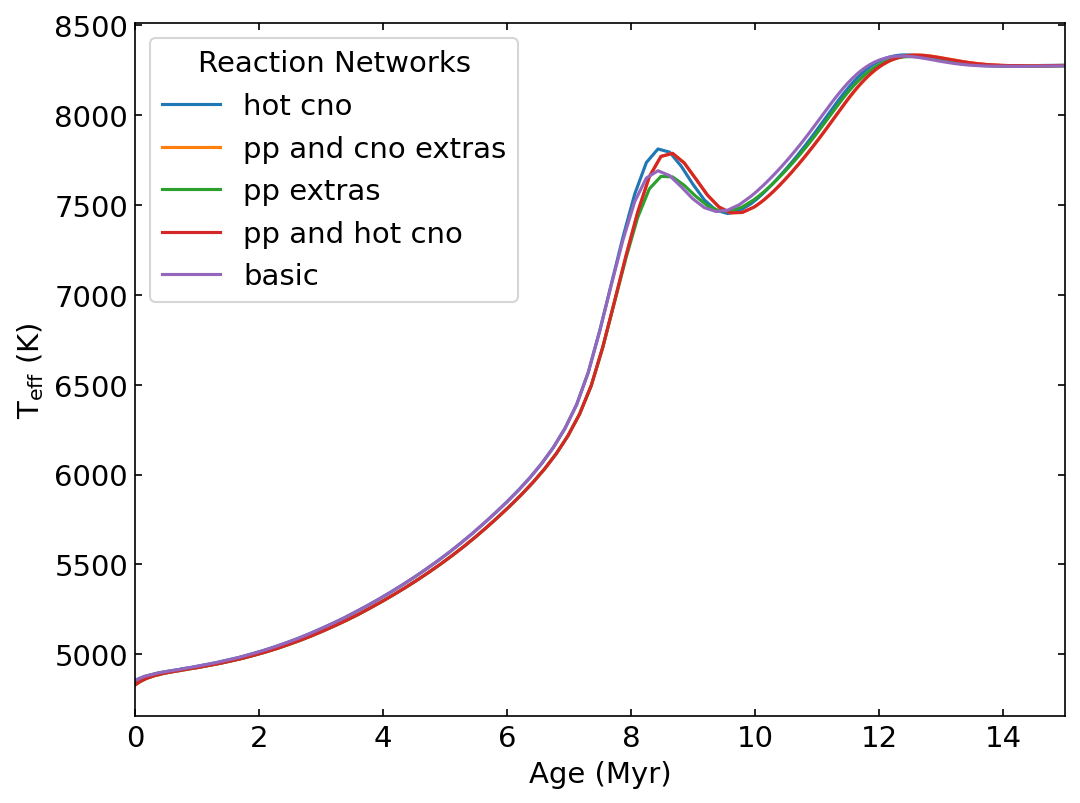

In [244]:
i = 0
plt.figure(figsize=(8, 6))
for logs_dir in logs_dirs:
    h = pd.read_csv(logs_dir+"/history.data", skiprows=5, delim_whitespace=True)
    age = h['star_age']/1e6
    Teff = h['log_Teff']
    plt.plot(age, 10**np.array(Teff), label=str(nets[i]))
    # plt.plot(age, Teff, label=str(nets[i]))
    i += 1
plt.xlim([0, 15])
plt.xlabel('Age (Myr)')
plt.ylabel(r'$\rm{T}_{\rm{eff}}$ (K)')
plt.legend(title="Reaction Networks", loc='upper left', fancybox=True)

In [233]:
10**3.778

5997.910762555094

In [241]:
freqs_df_all[0]

,age,Dnu,eps,n1ell0m0,n2ell0m0,n3ell0m0,n4ell0m0,n5ell0m0,n6ell0m0,n7ell0m0,...,n1ell1dfreq,n2ell1dfreq,n3ell1dfreq,n4ell1dfreq,n5ell1dfreq,n6ell1dfreq,n7ell1dfreq,n8ell1dfreq,n9ell1dfreq,n10ell1dfreq
0,15.0,7.464063,1.549531,22.700152,29.172960,35.286098,41.777533,48.879759,56.328049,63.849054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.0,7.466469,1.549816,22.707528,29.182942,35.298113,41.791231,48.895350,56.345738,63.869061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.0,7.469777,1.549403,22.717026,29.195016,35.312172,41.808077,48.915413,56.369018,63.895703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,7.473017,1.549000,22.726334,29.206854,35.325962,41.824595,48.935078,56.391833,63.921809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.0,7.473684,1.549000,22.728424,29.209744,35.329539,41.828682,48.939675,56.396996,63.927602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,659.0,5.783286,1.770802,17.986764,23.223011,28.459255,33.697905,39.176954,44.925306,50.706757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
645,660.0,5.780112,1.771291,17.977672,23.211335,28.445627,33.682122,39.158336,44.903449,50.681609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
646,661.0,5.776937,1.771779,17.968580,23.199659,28.432000,33.666339,39.139717,44.881592,50.656460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,662.0,5.773762,1.772267,17.959488,23.187984,28.418372,33.650555,39.121098,44.859735,50.631312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
